# Basic Flux Balance Analysis Implementation

## Introduction for Undergraduate Students

This notebook provides a hands-on introduction to Flux Balance Analysis (FBA), a computational approach that uses linear algebra to analyze metabolic networks. As seniors in undergraduate studies, you'll find that this technique bridges your knowledge of biochemistry, linear algebra, and computational biology.

### Learning Objectives
- Understand how to represent metabolic networks mathematically
- Implement FBA using Python and COBRApy
- Analyze and interpret flux distributions
- Explore alternative optimal solutions using Flux Variability Analysis
- Simulate genetic knockouts and predict their effects

### Prerequisites
- Basic understanding of metabolism (glycolysis, TCA cycle, etc.)
- Familiarity with linear algebra concepts (matrices, vectors, linear equations)
- Basic Python programming skills

Let's begin by setting up our environment and installing the necessary packages.

In [3]:
# Import necessary libraries
import cobra  # COBRApy for constraint-based modeling
import numpy as np  # NumPy for numerical operations
import pandas as pd  # Pandas for data manipulation
import matplotlib.pyplot as plt  # Matplotlib for plotting
import seaborn as sns  # Seaborn for enhanced visualizations

# Set plotting style
sns.set_palette('muted')
sns.set_context('notebook', font_scale=1.5)
sns.set_style("whitegrid")

# Display plots inline
%matplotlib inline

## Example 1: Creating a Simple Metabolic Model

### Understanding the Network Structure

We'll create a simple metabolic network with the following reactions:
- R1: A → B (Conversion of metabolite A to B)
- R2: B → C (Conversion of B to C)
- R3: C → D (Conversion of C to D)
- R4: B → E (Alternative pathway: B to E)
- R5: E → D (Conversion of E to D)
- EX_A: → A (Exchange reaction for A, representing uptake from environment)
- EX_D: D → (Exchange reaction for D, representing secretion to environment)

This network represents a simplified metabolic pathway with:
- A primary pathway (A → B → C → D)
- An alternative pathway (A → B → E → D)
- A single input (A) and output (D)

### Mathematical Representation

In FBA, this network is represented by a stoichiometric matrix S where:
- Rows represent metabolites (A, B, C, D, E)
- Columns represent reactions (R1, R2, R3, R4, R5, EX_A, EX_D)
- Values represent stoichiometric coefficients

Let's implement this model using COBRApy:

In [10]:
# Create an empty model
model = cobra.Model('simple_model')

# Create metabolites
# Each metabolite is created with an ID and compartment ('c' for cytosol)
A = cobra.Metabolite('A', compartment='c')
B = cobra.Metabolite('B', compartment='c')
C = cobra.Metabolite('C', compartment='c')
D = cobra.Metabolite('D', compartment='c')
E = cobra.Metabolite('E', compartment='c')

# Create reactions
# For each reaction, we define:
# 1. ID and name
# 2. Lower and upper bounds (flux constraints)
# 3. Metabolites involved with their stoichiometric coefficients

# R1: A → B
r1 = cobra.Reaction('R1')
r1.name = 'Reaction 1 (A -> B)'
r1.lower_bound = 0  # Irreversible reaction (flux can't be negative)
r1.upper_bound = 1000  # Maximum flux (arbitrary large number)
r1.add_metabolites({A: -1, B: 1})  # -1 for substrate, +1 for product

# R2: B → C
r2 = cobra.Reaction('R2')
r2.name = 'Reaction 2 (B -> C)'
r2.lower_bound = 0
r2.upper_bound = 1000
r2.add_metabolites({B: -1, C: 1})

# R3: C → D
r3 = cobra.Reaction('R3')
r3.name = 'Reaction 3 (C -> D)'
r3.lower_bound = 0
r3.upper_bound = 1000
r3.add_metabolites({C: -1, D: 1})

# R4: B → E (alternative pathway)
r4 = cobra.Reaction('R4')
r4.name = 'Reaction 4 (B -> E)'
r4.lower_bound = 0
r4.upper_bound = 1000
r4.add_metabolites({B: -1, E: 1})

# R5: E → D
r5 = cobra.Reaction('R5')
r5.name = 'Reaction 5 (E -> D)'
r5.lower_bound = 0
r5.upper_bound = 1000
r5.add_metabolites({E: -1, D: 1})

# Create exchange reactions
# Exchange reactions represent the system boundary
# They allow metabolites to enter or exit the system

# EX_A: → A (uptake of A)
ex_a = cobra.Reaction('EX_A')
ex_a.name = 'Exchange reaction for A'
ex_a.lower_bound = 0  # A can only enter the system (not exit)
ex_a.upper_bound = 10  # Maximum uptake rate is 10 units
ex_a.add_metabolites({A: 1})  # +1 because A is produced (enters the system)

# EX_D: D → (secretion of D)
ex_d = cobra.Reaction('EX_D')
ex_d.name = 'Exchange reaction for D'
ex_d.lower_bound = -1000  # D can only leave the system (not enter)
ex_d.upper_bound = 0
ex_d.add_metabolites({D: -1})  # -1 because D is consumed (exits the system)

# Add all reactions to the model
model.add_reactions([r1, r2, r3, r4, r5, ex_a, ex_d])

# Set objective function to maximize production of D
# This means we want to maximize the flux through EX_D
model.objective = 'EX_D'
model.objective_direction = 'max'  # Maximize production of D

# Print the model summary
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
Metabolite,Reaction,Flux,C-Number,C-Flux


### Understanding the Model Summary

The model summary provides an overview of:
1. **Objective function**: What we're trying to maximize (production of D)
2. **Reactions**: Total number of reactions in the model
3. **Metabolites**: Total number of metabolites in the model
4. **Genes**: Any genes associated with reactions (none in our simple model)
5. **Input/Output fluxes**: Which metabolites are entering and leaving the system

## Visualize the Stoichiometric Matrix

The stoichiometric matrix (S) is the mathematical core of FBA. Each row represents a metabolite, each column represents a reaction, and each value represents the stoichiometric coefficient of that metabolite in that reaction.

For example, for reaction R1 (A → B):
- The coefficient for A is -1 (consumed)
- The coefficient for B is +1 (produced)
- The coefficients for C, D, and E are 0 (not involved)

Let's extract and visualize this matrix:

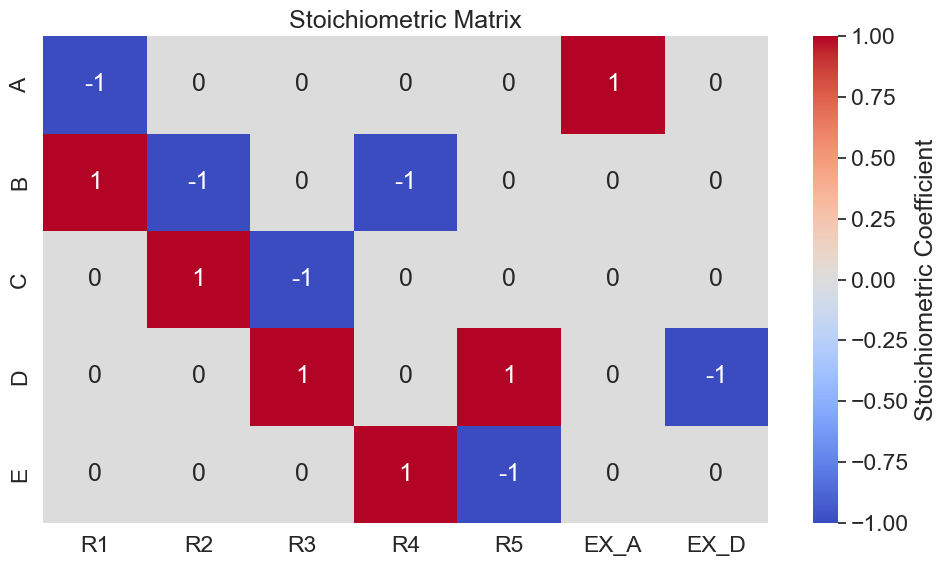

In [11]:
# Extract the stoichiometric matrix
S = cobra.util.array.create_stoichiometric_matrix(model)

# Get metabolite and reaction names for labeling
metabolites = [met.id for met in model.metabolites]
reactions = [rxn.id for rxn in model.reactions]

# Create a DataFrame for better visualization
S_df = pd.DataFrame(S, index=metabolites, columns=reactions)

# Plot the stoichiometric matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(S_df, cmap='coolwarm', center=0, annot=True, fmt='.0f', cbar_kws={'label': 'Stoichiometric Coefficient'})
plt.title('Stoichiometric Matrix')
plt.tight_layout()
plt.show()

### Interpreting the Stoichiometric Matrix

In the heatmap above:
- **Blue cells (-1)** represent metabolites being consumed in a reaction
- **Red cells (+1)** represent metabolites being produced in a reaction
- **White cells (0)** represent metabolites not involved in a reaction

This matrix is the foundation of the steady-state constraint in FBA:

$$S \cdot v = 0$$

Where:
- $S$ is the stoichiometric matrix
- $v$ is the vector of reaction fluxes
- $0$ is a vector of zeros (representing steady state)

This constraint ensures that for each metabolite, the rate of production equals the rate of consumption, maintaining steady state.

## Run Flux Balance Analysis

Now that we have our model set up, let's run FBA to find the optimal flux distribution that maximizes the production of metabolite D while satisfying all constraints.

In [22]:
# Run FBA
solution = model.optimize()

# Print the solution status
print(f"Solution status: {solution.status}")
print(f"Objective value: {solution.objective_value:.4f}")

# Get the flux distribution
fluxes = solution.fluxes
print("\nFlux Distribution:")
for rxn_id, flux in fluxes.items():
    print(f"{rxn_id}: {flux:.4f}")

Solution status: optimal
Objective value: 0.0000

Flux Distribution:
R1: 0.0000
R2: 0.0000
R3: 0.0000
R4: 0.0000
R5: 0.0000
EX_A: 0.0000
EX_D: 0.0000


### Understanding the FBA Solution

The FBA solution provides:

1. **Solution status**: 'optimal' means a valid solution was found
2. **Objective value**: The maximum possible production rate of D
3. **Flux distribution**: The optimal flux through each reaction

#### Key Insights:

- The objective value equals the maximum uptake rate of A (10 units), indicating that all available A is converted to D
- The flux distribution shows which pathway the model uses to convert A to D
- Some reactions may have zero flux, indicating they're not used in the optimal solution

Let's visualize this flux distribution to better understand the pathway usage:

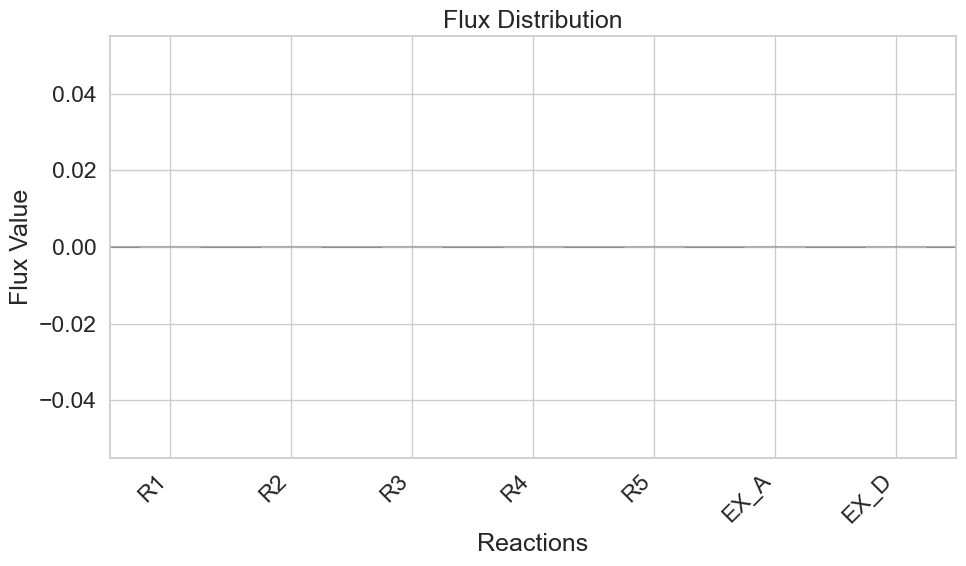

In [13]:
# Plot the flux distribution
plt.figure(figsize=(10, 6))
fluxes.plot(kind='bar', color='skyblue')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Flux Distribution')
plt.xlabel('Reactions')
plt.ylabel('Flux Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Interpreting the Flux Distribution

The bar chart shows the flux through each reaction in the optimal solution. Positive values indicate forward flux, while negative values would indicate reverse flux (though all our reactions are irreversible).

#### Pathway Analysis:

- **EX_A**: Uptake of A at the maximum rate (10 units)
- **R1**: Conversion of all A to B (10 units)
- **R2 and R4**: Distribution of B between the two possible pathways
- **R3 and R5**: Conversion of C and E to D
- **EX_D**: Secretion of D (negative because it's leaving the system)

The model has chosen a specific distribution between the two pathways (R2→R3 vs. R4→R5) to maximize D production. However, there might be alternative optimal solutions with different pathway distributions that achieve the same objective value.

## Flux Variability Analysis

To explore alternative optimal solutions, we'll perform Flux Variability Analysis (FVA). This technique finds the minimum and maximum possible flux values for each reaction while maintaining the optimal objective value.

## Plot the network 
Create the outputs for Cytoscape
https://cytoscape.org

In [18]:
import pandas as pd

rows = []
sol = model.optimize()
fx = sol.fluxes.to_dict()

for r in model.reactions:
    mets = r.metabolites
    if r.id.startswith("EX_") and len(mets)==1:
        (m,c), = mets.items()
        u,v = ("External", m.id) if c>0 else (m.id,"External")
        rows.append((u,v,r.id,fx.get(r.id,0.0)))
    else:
        subs=[m.id for m,c in mets.items() if c<0]
        prods=[m.id for m,c in mets.items() if c>0]
        for s in subs:
            for p in prods:
                rows.append((s,p,r.id,fx.get(r.id,0.0)))

df = pd.DataFrame(rows, columns=["source","target","reaction","flux"])
df.to_csv("flux_edges.csv", index=False)
print("Open flux_edges.csv in Cytoscape; set edge width = |flux|.")


Open flux_edges.csv in Cytoscape; set edge width = |flux|.
